# **Micro Facial Expression Detection (Lie,Truth)**

---

**Orignal Dataset** = Micro Expression Dataset for Lie Detection --> https://www.kaggle.com/datasets/devvratmathur/micro-expression-dataset-for-lie-detection By: Devvrat Mathur

**Edited Dataset** = https://www.kaggle.com/datasets/mohammadabuayyash1/micro-data By: Mohammad Abu Ayyash

---

**Micro expressions can occur either as the result of conscious suppression or unconscious repression of emotions. As such, spotting micro expressions (or analyzing facial expressions) is key to learning how to detect lies, unveiling concealed emotions, and deception.**

**By: Mohammad Abu Ayyash**

# Imports

In [ ]:
!pip install keras-tuner
!pip install visualkeras

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mohammadabuayyash1/micro-data")

print("Path to dataset files:", path)

100%|██████████| 7.72G/7.72G [01:25<00:00, 97.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mohammadabuayyash1/micro-data/versions/1


In [3]:
import os,glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import PIL
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras import layers, models, optimizers, metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import visualkeras as vk
import keras_tuner as kt
from keras_tuner import HyperParameters as hp
from sklearn.metrics import accuracy_score, confusion_matrix,recall_score,precision_score,classification_report,ConfusionMatrixDisplay
folder='Keras_tuner'
os.makedirs(folder, exist_ok=True)

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

## Custom Functions

In [5]:
def plot_history(history, figsize=(6,12), marker='o'):

    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]

    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)


    # For each metric
    for i, metric_name in enumerate(metrics):
        # Get the axis for the current metric
        if len(metrics)==1:
            ax = axes
        else:
            ax = axes[i]

        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch

        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)

        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)

        # Final subplot adjustments
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()
    return fig, axes

In [6]:

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False, values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)

    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)

    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)

    # Create a confusion matrix of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None,
                                            cmap="gist_gray_r", # Updated cmap
                                            values_format="d",
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")

    # Create a confusion matrix with the data with normalize argument
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap,
                                            values_format=values_format, # New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")

    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()

    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict

In [7]:
def evaluate_classification(model, X_train, y_train, X_test, y_test,figsize=(6,4), normalize='true',
    output_dict = False,cmap_train='Blues', cmap_test="Reds",colorbar=False):
  y_train_pred = model.predict(X_train)
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
    output_dict=True, figsize=figsize,colorbar=colorbar, cmap=cmap_train,label='Training Data')
  print()
  y_test_pred = model.predict(X_test)
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
    output_dict=True,figsize=figsize,colorbar=colorbar, cmap=cmap_test,label='Test Data')
  if output_dict == True:
    results_dict = {'train':results_train,'test': results_test}
    return results_dict

In [8]:
def convert_y_to_sklearn_classes(y, verbose=False):
    # If already one-dimension
    if np.ndim(y)==1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y

    # If 2 dimensions with more than 1 column:
    elif y.shape[1]>1:
        if verbose:
            print("- y is 2D with >1 column. Using argmax for metrics.")
        return np.argmax(y, axis=1)

    else:
        if verbose:
            print("y is 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)


In [9]:
def get_true_pred_labels(model, ds):
    """Gets the labels and predicted probabilities from a Tensorflow model and Dataset object.
       Adapted from source: https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac
    """
    y_true = []
    y_pred_probs = []

    # Loop through the dataset as a numpy iterator
    for images, labels in ds.as_numpy_iterator():

        # Get prediction with batch_size=1
        y_probs = model.predict(images, batch_size=1, verbose=0)
        # Combine previous labels/preds with new labels/preds
        y_true.extend(labels)
        y_pred_probs.extend(y_probs)

    ## Convert the lists to arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)

    return y_true, y_pred_probs


In [10]:
def evaluate_classification_network(model,
                                    X_train=None, y_train=None,
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,4), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test='Reds',
                                    values_format=".2f",
                                    colorbar=False):
    """Evaluates a neural network classification task using either
       separate X and y arrays or a tensorflow Dataset

    Data Args:
        X_train (array, or Dataset)
        y_train (array, or None if using a Dataset)
        X_test (array, or Dataset)
        y_test (array, or None if using a Dataset)
        history (history object)
    """
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)
    # Adding a Print Header
    print("\n" + '='*80)
    print(" - Evaluating Network...")
    print('='*80)

    # TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        if hasattr(X_train, 'map'):
            # If it is a Dataset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)
        # Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)

        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred,
                                               output_dict=True, figsize=figsize,
                                               colorbar=colorbar, cmap=cmap_train,
                                               values_format=values_format,
                                               label="Training Data")

        ## Run model.evaluate
        print("\n- Evaluating Training Data:")
        print(model.evaluate(X_train, return_dict=True))
    else:
        results_train = []

    ## TEST DATA EVALUATION
    # Check if X_test was provided
    if X_test is not None:
        ## Check if X_test is a dataset
        if hasattr(X_test, 'map'):
            # If it is a Dataset:
            # extract y_test and y_test_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)
        # Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)

        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred,
                                              output_dict=True, figsize=figsize,
                                              colorbar=colorbar, cmap=cmap_test,
                                              values_format=values_format,
                                              label="Test Data")

        ## Run model.evaluate
        print("\n- Evaluating Test Data:")
        print(model.evaluate(X_test, return_dict=True))
    else:
        results_test = []

    # Store results in a dictionary
    results_dict = {'train': results_train,
                    'test': results_test}

    if output_dict == True:
        return results_dict

# Data Loading

In [11]:
data = '/root/.cache/kagglehub/datasets/mohammadabuayyash1/micro-data/versions/1/Micro'

In [12]:
img_files = glob.glob(data+"**/**/*", recursive=True)
len(img_files)

23478

In [13]:
train_folder = data+'/Train'
print(train_folder)
len(glob.glob(train_folder+"/**/*"))

/root/.cache/kagglehub/datasets/mohammadabuayyash1/micro-data/versions/1/Micro/Train


17634

In [14]:
test_folder = data+'/Test'
print(test_folder)
len(glob.glob(test_folder+"/**/*"))

/root/.cache/kagglehub/datasets/mohammadabuayyash1/micro-data/versions/1/Micro/Test


5838

# Data Split

In [15]:
batch_size = 32
img_height = 64
img_width = 64

In [16]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_folder,
  shuffle=True,
  batch_size=batch_size,
  label_mode='categorical',
  seed=42,
  image_size=(img_height, img_width))

Found 17634 files belonging to 2 classes.


In [17]:
test_ds,val_ds = tf.keras.utils.image_dataset_from_directory(
  test_folder,
  shuffle=True,
  subset='both',
  validation_split=0.5,
  batch_size=batch_size,
  label_mode='categorical',
  seed=42,
  image_size=(img_height, img_width))

Found 5838 files belonging to 2 classes.
Using 2919 files for training.
Using 2919 files for validation.


In [18]:
class_names = train_ds.class_names
print("Training classes:", class_names)

class_names = test_ds.class_names
print("Test classes:", class_names)

class_names = val_ds.class_names
print("Validation classes:", class_names)

Training classes: ['Lie', 'Truth']
Test classes: ['Lie', 'Truth']
Validation classes: ['Lie', 'Truth']


In [19]:
class_dict = dict(zip(range(len(class_names)), class_names))
print(class_dict)

{0: 'Lie', 1: 'Truth'}


# Data Inspctiation

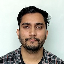

In [20]:
for images, labels in train_ds.take(1):
  for i in range(images.shape[0]):
    img_loaded = array_to_img(images[i])  # Convert the tensor to a PIL Image
    display(img_loaded)
    break  # Display only the first image of the batch
  break

In [21]:
img_data = img_to_array(img_loaded)
img_data.shape

(64, 64, 3)

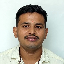

In [22]:
for images, labels in test_ds.take(1):
  for i in range(images.shape[0]):
    img_loaded = array_to_img(images[i])  # Convert the tensor to a PIL Image
    display(img_loaded)
    break  # Display only the first image of the batch
  break

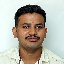

In [23]:
for images, labels in val_ds.take(1):
  for i in range(images.shape[0]):
    img_loaded = array_to_img(images[i])  # Convert the tensor to a PIL Image
    display(img_loaded)
    break  # Display only the first image of the batch
  break

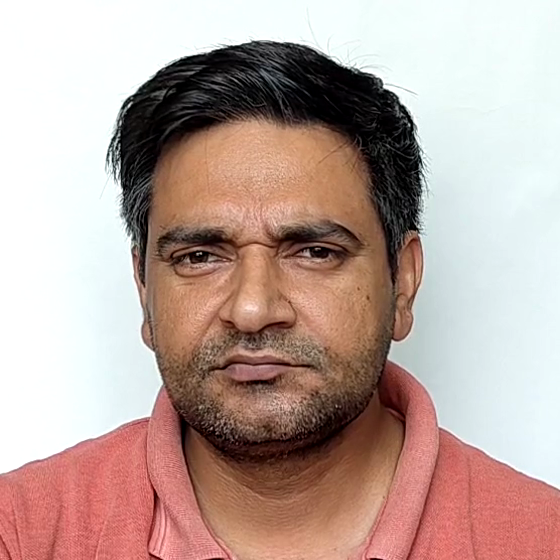

In [24]:
img_loaded = None

for file_path in img_files:
  if os.path.isfile(file_path):
    img_loaded = load_img(file_path)
    break

if img_loaded is not None:
  display(img_loaded)
else:
  print("No valid image files found in the list.")

In [25]:
img_data = img_to_array(img_loaded)
img_data.shape

(560, 560, 3)

# Img Prosessing

In [26]:
example_batch_imgs,example_batch_y=train_ds.take(1).get_single_element()
example_batch_imgs.shape

TensorShape([32, 64, 64, 3])

In [27]:
display(example_batch_y[0])
print(example_batch_y[0].shape)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 0.], dtype=float32)>

(2,)


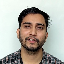

In [28]:
array_to_img(example_batch_imgs[0])

# Modeling

## Model 1

In [29]:
input_shape = example_batch_imgs[0].shape
input_shape

TensorShape([64, 64, 3])

In [30]:
def build_model():

    # Model Layer
    model = models.Sequential(name='Lie_Truth_Model')

    # Scaling Layer
    scalled_layer = layers.Rescaling(1./255, input_shape=input_shape)
    model.add(scalled_layer)

    # Conv. Layer 1
    model.add(layers.Conv2D(filters=16,kernel_size=3,padding='same'))

    # Pooling Layer 1
    model.add(layers.MaxPooling2D(pool_size=2,strides=1))

    # Conv. Layer 2
    model.add(layers.Conv2D(filters=16,kernel_size=3,padding='same'))

    # Pooling Layer 2
    model.add(layers.MaxPooling2D(pool_size=2,strides=1))

    # Flattening Layer
    model.add(layers.Flatten())

    # Output Layer
    model.add(layers.Dense(len(class_names), activation='sigmoid'))

    # Model Compile
    model.compile(optimizer='adam',loss='bce',metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    model.summary()

    return model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "Lie_Truth_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 63, 63, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61504)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │         123,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 125,778 (491.32 KB)

 Trainable params: 125,778 (491.32 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


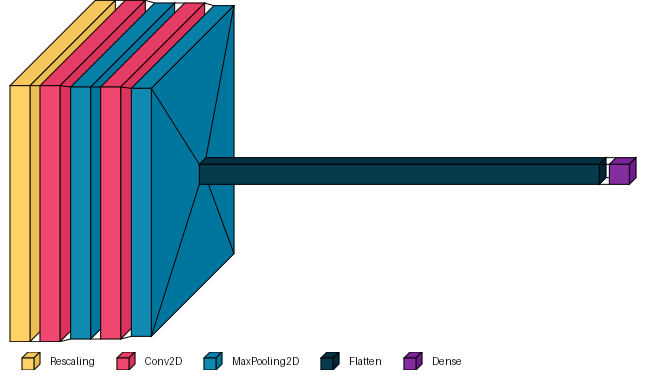

In [31]:
model1 = build_model()
vk.layered_view(model1,legend=True)

In [32]:
model1.summary()

Model: "Lie_Truth_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 63, 63, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61504)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │         123,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 125,778 (491.32 KB)

 Trainable params: 125,778 (491.32 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
def get_callbacks(patience=5,monitor='val_accuracy'):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor=monitor,patience=patience)
  return [early_stopping]

In [34]:
history1 = model1.fit(train_ds,validation_data=val_ds,epochs=5,callbacks=get_callbacks(),batch_size=batch_size,verbose=1)

Epoch 1/5
552/552 ━━━━━━━━━━━━━━━━━━━━ 342s 616ms/step - accuracy: 0.8493 - loss: 0.3722 - precision: 0.8484 - recall: 0.8482 - val_accuracy: 0.7595 - val_loss: 1.0067 - val_precision: 0.7585 - val_recall: 0.7629
Epoch 2/5
552/552 ━━━━━━━━━━━━━━━━━━━━ 336s 608ms/step - accuracy: 0.9939 - loss: 0.0227 - precision: 0.9939 - recall: 0.9940 - val_accuracy: 0.7763 - val_loss: 1.2225 - val_precision: 0.7837 - val_recall: 0.7622
Epoch 3/5
552/552 ━━━━━━━━━━━━━━━━━━━━ 387s 617ms/step - accuracy: 0.9989 - loss: 0.0062 - precision: 0.9990 - recall: 0.9987 - val_accuracy: 0.7732 - val_loss: 1.4271 - val_precision: 0.7722 - val_recall: 0.7746
Epoch 4/5
552/552 ━━━━━━━━━━━━━━━━━━━━ 345s 625ms/step - accuracy: 1.0000 - loss: 0.0013 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.7831 - val_loss: 1.5321 - val_precision: 0.7965 - val_recall: 0.7482
Epoch 5/5
552/552 ━━━━━━━━━━━━━━━━━━━━ 335s 607ms/step - accuracy: 0.9972 - loss: 0.0348 - precision: 0.9899 - recall: 0.9905 - val_accuracy: 0.8034


 - Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8375
           1       1.00      1.00      1.00      9259

    accuracy                           1.00     17634
   macro avg       1.00      1.00      1.00     17634
weighted avg       1.00      1.00      1.00     17634



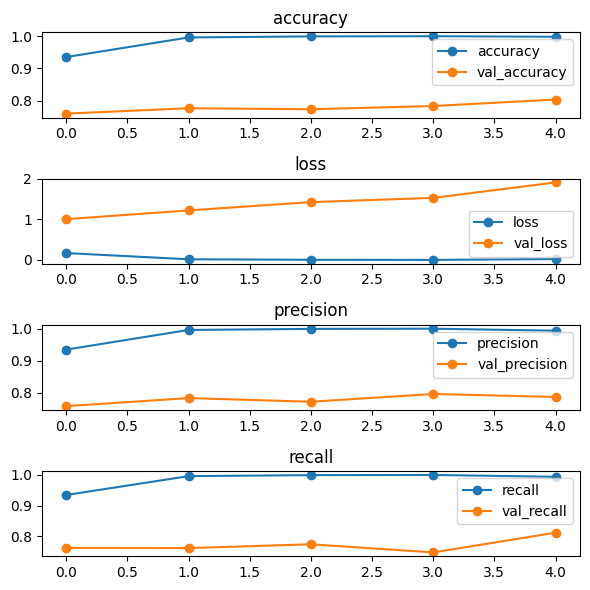

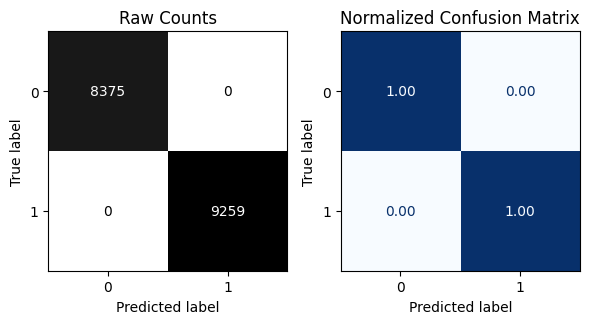


- Evaluating Training Data:
552/552 ━━━━━━━━━━━━━━━━━━━━ 33s 60ms/step - accuracy: 1.0000 - loss: 6.3230e-04 - precision: 1.0000 - recall: 0.9999
{'accuracy': 1.0, 'loss': 0.0006150263361632824, 'precision': 1.0, 'recall': 0.9998865723609924}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.77      0.79      1411
           1       0.79      0.82      0.81      1508

    accuracy                           0.80      2919
   macro avg       0.80      0.80      0.80      2919
weighted avg       0.80      0.80      0.80      2919



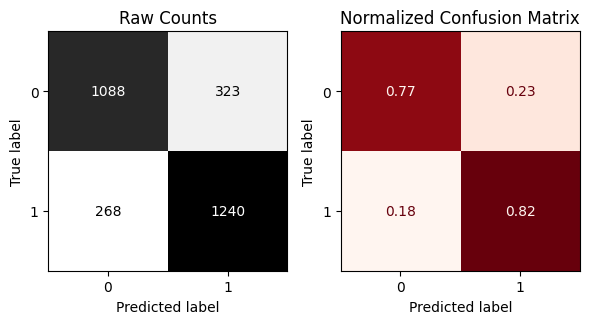


- Evaluating Test Data:
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.8098 - loss: 1.9508 - precision: 0.7928 - recall: 0.8123
{'accuracy': 0.797533392906189, 'loss': 2.0013957023620605, 'precision': 0.7786666750907898, 'recall': 0.8002740740776062}


In [42]:
evaluate_classification_network(model1,X_train=train_ds,X_test=test_ds,history=history1);

## Tunning Dataset

In [36]:
AUTOTUNE = tf.data.AUTOTUNE
buffer_size = len(train_ds)
buffer_size

552

In [37]:
train_ds = train_ds.cache().shuffle(buffer_size=buffer_size,seed=42).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model 2

In [38]:
def build_model2():

    # Model Layer
    model = models.Sequential(name='Lie_Truth_Model_2')

    # Scaling Layer
    scalled_layer = layers.Rescaling(1./255, input_shape=input_shape)
    model.add(scalled_layer)

    # Conv. Layer 1
    model.add(layers.Conv2D(filters=16,kernel_size=3,padding='same'))

    # Pooling Layer 1
    model.add(layers.MaxPooling2D(pool_size=2,strides=1))

    # Conv. Layer 2
    model.add(layers.Conv2D(filters=16,kernel_size=3,padding='same'))

    # Pooling Layer 2
    model.add(layers.MaxPooling2D(pool_size=2,strides=1))

    # Flattening Layer
    model.add(layers.Flatten())

    # Hiddin Dense
    model.add(layers.Dense(64,activation='relu'))

    # Dropout Layer
    model.add(layers.Dropout(0.2)) # ADDED Dropout

    # Output Layer
    model.add(layers.Dense(len(class_names), activation='sigmoid'))

    # Model Compile
    model.compile(optimizer='adam',loss='bce',metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    model.summary()

    return model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "Lie_Truth_Model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 63, 63, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 62, 62, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 61504)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │       3,936,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,939,218 (15.03 MB)

 Trainable params: 3,939,218 (15.03 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


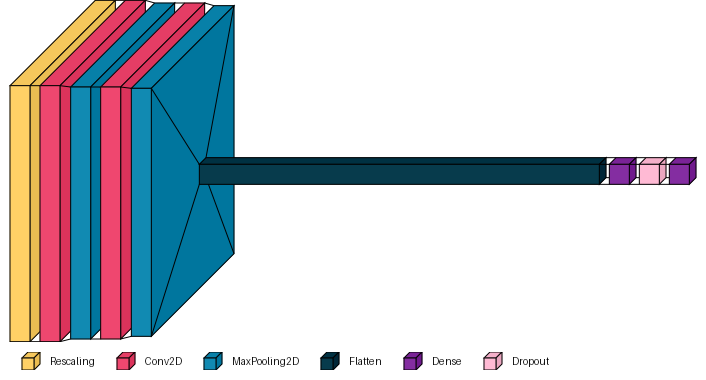

In [39]:
model2 = build_model2()
vk.layered_view(model2,legend=True)

In [40]:
history2 = model2.fit(train_ds,validation_data=val_ds,epochs=10,callbacks=get_callbacks())

Epoch 1/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 387s 371ms/step - accuracy: 0.8071 - loss: 0.5442 - precision_1: 0.7993 - recall_1: 0.8071 - val_accuracy: 0.7523 - val_loss: 1.1479 - val_precision_1: 0.7460 - val_recall_1: 0.7557
Epoch 2/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 172s 312ms/step - accuracy: 0.9820 - loss: 0.0464 - precision_1: 0.9822 - recall_1: 0.9817 - val_accuracy: 0.7670 - val_loss: 1.2494 - val_precision_1: 0.7639 - val_recall_1: 0.7739
Epoch 3/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 167s 303ms/step - accuracy: 0.9950 - loss: 0.0166 - precision_1: 0.9950 - recall_1: 0.9945 - val_accuracy: 0.7801 - val_loss: 1.4732 - val_precision_1: 0.7819 - val_recall_1: 0.7773
Epoch 4/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 165s 299ms/step - accuracy: 0.9872 - loss: 0.0340 - precision_1: 0.9881 - recall_1: 0.9851 - val_accuracy: 0.7622 - val_loss: 1.6966 - val_precision_1: 0.7605 - val_recall_1: 0.7605
Epoch 5/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 179s 324ms/step - accuracy: 0.9956 - loss: 0.0106 - precision_1: 0.9967 


 - Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8375
           1       1.00      1.00      1.00      9259

    accuracy                           1.00     17634
   macro avg       1.00      1.00      1.00     17634
weighted avg       1.00      1.00      1.00     17634



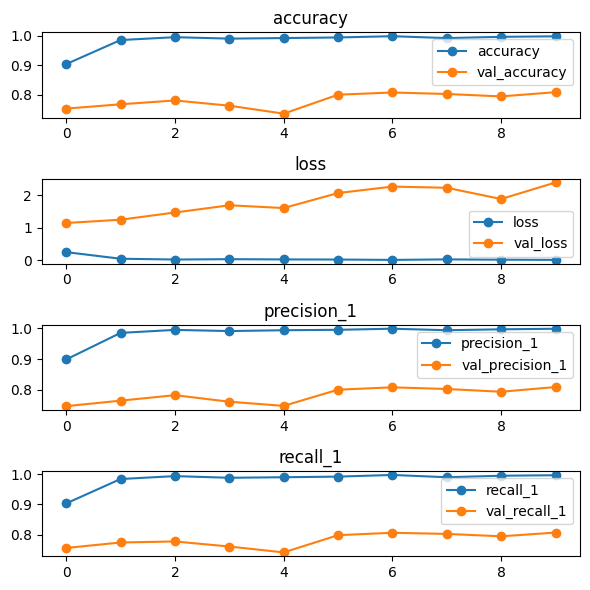

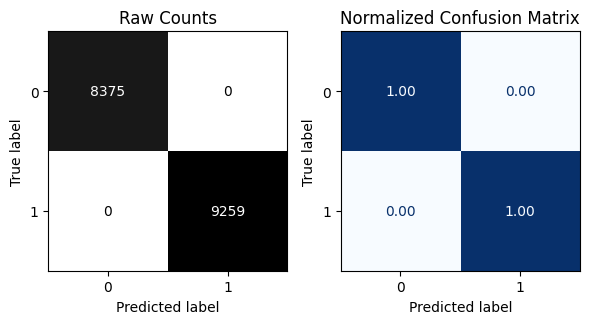


- Evaluating Training Data:
552/552 ━━━━━━━━━━━━━━━━━━━━ 36s 66ms/step - accuracy: 1.0000 - loss: 3.6301e-06 - precision_1: 1.0000 - recall_1: 1.0000
{'accuracy': 1.0, 'loss': 5.111955942993518e-06, 'precision_1': 1.0, 'recall_1': 1.0}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.75      0.79      1411
           1       0.79      0.85      0.82      1508

    accuracy                           0.81      2919
   macro avg       0.81      0.80      0.81      2919
weighted avg       0.81      0.81      0.81      2919



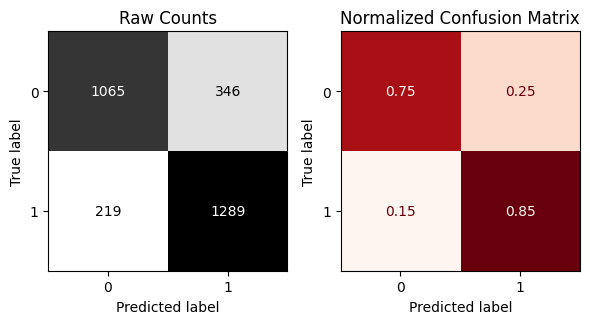


- Evaluating Test Data:
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.8140 - loss: 2.4237 - precision_1: 0.8143 - recall_1: 0.8146
{'accuracy': 0.806440532207489, 'loss': 2.499415636062622, 'precision_1': 0.8058884143829346, 'recall_1': 0.806440532207489}


In [41]:
evaluate_classification_network(model2,X_train=train_ds,X_test=test_ds,history=history2);

# Save and Load Model

In [43]:
best_model = model2

In [44]:
import os
folder = 'best_model'
os.makedirs(folder,exist_ok=True)
model_fname = "best_model/Lie_Truth.keras"
best_model.save(model_fname)

In [45]:
path ='/content/best_model/Lie_Truth.keras'

In [46]:
load_model = tf.keras.models.load_model(path)
load_model.summary()

Model: "Lie_Truth_Model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 63, 63, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 62, 62, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 61504)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │       3,936,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,817,656 (45.08 MB)

 Trainable params: 3,939,218 (15.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,878,438 (30.05 MB)

# Test Loaded Model

In [48]:
# TEST PREDICTION

# Load the image
img = load_img('/content/2k.jpg', target_size=(64, 64))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Make predictions
predictions = load_model.predict(img_array)

# Process predictions
predicted_class = np.argmax(predictions[0])
print(f"Predicted class: {predicted_class}")
print(f"Class probabilities: {predictions[0]}")

predicted_class_name = class_dict.get(predicted_class, "Unknown")
print(f"Predicted class name: {predicted_class_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Predicted class: 1
Class probabilities: [0.10122465 0.7032195 ]
Predicted class name: Truth
